#Урок 5. Задача оттока: варианты постановки, возможные способы решения

__1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:__

   - бустинг
   - логистическая регрессия





In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O churn_data.csv

--2022-03-24 14:52:41--  https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91
Resolving drive.google.com (drive.google.com)... 74.125.137.139, 74.125.137.102, 74.125.137.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/di891pen020i6knbfinolkgs0i6e1mgr/1648133550000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download [following]
--2022-03-24 14:52:41--  https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/di891pen020i6knbfinolkgs0i6e1mgr/1648133550000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download
Resolving doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs.googleusercontent.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
# распределение классов:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        print(test_columns)
        for col_ in self.columns:
            print(col_)
            if col_ not in test_columns:
                print('ll')
                X[col_] = 0
        return X[self.columns]

class DataForLr(MinMaxScaler):
   def __init__(self, key):
       self.key = key
       self.scaler = MinMaxScaler(feature_range=(-1, 1))

   def fit(self, X, y=None):
       self.columns = [col for col in X.columns]
       self.scaler.fit(X[self.columns])
       return self

   def transform(self, X):
       return self.scaler.transform(X[self.columns])


In [8]:
# Зададим списки признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# под каждый признак создаём трансформер и объединяем их в список
final_transformers_1 = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col)),
                ('data_for_lr', DataForLr(key=cat_col))
            ])
    
    final_transformers_1.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('data_for_lr', DataForLr(key=cont_col))
            ])
    
    final_transformers_1.append((cont_col, cont_transformer))

In [10]:
# Объединим все это в единый пайплайн
feats_1 = FeatureUnion(final_transformers_1)

feature_processing = Pipeline([('feats', feats_1)])

In [11]:
# Добавим модель LogisticRegression
from sklearn.linear_model import LogisticRegression

pipeline_1 = Pipeline([
    ('features', feats_1),
    ('classifier', LogisticRegression(random_state=42))
])

In [12]:
# обучим наш пайплайн
pipeline_1.fit(X_train, y_train)

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography')),
                                                                 ('data_for_lr',
                                                                  DataForLr(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OH

In [13]:
# наши прогнозы для тестовой выборки
preds_1 = pipeline_1.predict_proba(X_test)[:, 1]
preds_1[:10]

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


array([0.24383926, 0.08223503, 0.31103466, 0.43018407, 0.06406151,
       0.04588834, 0.27310368, 0.21125895, 0.32262376, 0.31077119])

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_1)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.9140362540186621, F-Score=nan, Precision=0.000, Recall=0.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Функция для отрисовки матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2003    0]
 [ 497    0]]


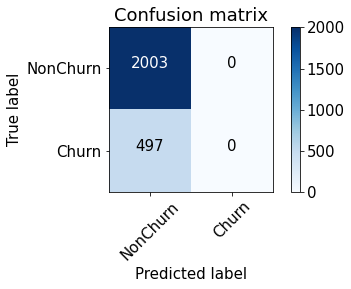

In [17]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_1 > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
# Добавим модель BaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

pipeline_2 = Pipeline([
    ('features', feats_1),
    ('classifier', BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, random_state=42))
])

In [19]:
# обучим наш пайплайн
pipeline_2.fit(X_train, y_train)

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography')),
                                                                 ('data_for_lr',
                                                                  DataForLr(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OH

In [20]:
# наши прогнозы для тестовой выборки
preds_2 = pipeline_2.predict_proba(X_test)[:, 1]
preds_2[:10]

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


array([0.3 , 0.12, 0.34, 0.24, 0.14, 0.06, 0.22, 0.48, 0.36, 0.28])

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_2)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.24, F-Score=0.511, Precision=0.410, Recall=0.678


Confusion matrix, without normalization
[[1571  432]
 [ 187  310]]


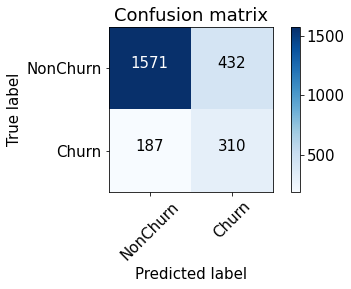

In [22]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_2 > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [23]:
# под каждый признак создаём трансформер и объединяем их в список
final_transformers_2 = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers_2.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers_2.append((cont_col, cont_transformer))

In [24]:
# Объединим все это в единый пайплайн
feats_2 = FeatureUnion(final_transformers_2)

feature_processing = Pipeline([('feats', feats_2)])

In [25]:
# Добавим модель GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

pipeline_3 = Pipeline([
    ('features', feats_2),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42))
])

In [26]:
# обучим наш пайплайн
pipeline_3.fit(X_train, y_train)

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [27]:
# наши прогнозы для тестовой выборки
preds_3 = pipeline_3.predict_proba(X_test)[:, 1]
preds_3[:10]

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


array([0.04915596, 0.04717297, 0.16303848, 0.23289913, 0.06021674,
       0.02546057, 0.13068309, 0.33180376, 0.42068687, 0.31131555])

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_3)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35841976516814406, F-Score=0.619, Precision=0.632, Recall=0.606


Confusion matrix, without normalization
[[1828  175]
 [ 197  300]]


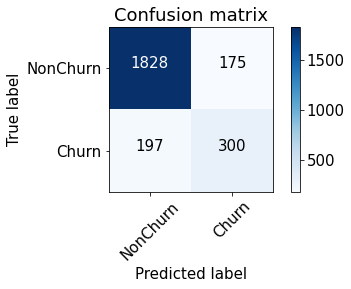

In [29]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_3 > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
# Добавим модель AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

pipeline_4 = Pipeline([
    ('features', feats_2),
    ('classifier', AdaBoostClassifier(n_estimators=100, random_state=42))
])

In [31]:
# обучим наш пайплайн
pipeline_4.fit(X_train, y_train)

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [32]:
# наши прогнозы для тестовой выборки
preds_4 = pipeline_4.predict_proba(X_test)[:, 1]
preds_4[:10]

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


array([0.49302798, 0.49171841, 0.49549509, 0.49687691, 0.49335807,
       0.48984875, 0.49541725, 0.49768212, 0.49880836, 0.49808459])

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_4)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4985183117778321, F-Score=0.613, Precision=0.624, Recall=0.604


Confusion matrix, without normalization
[[1822  181]
 [ 198  299]]


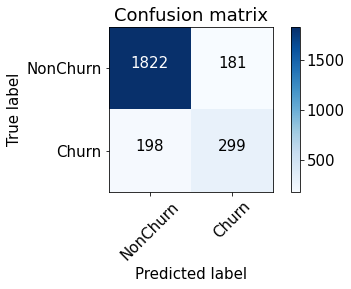

In [34]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_4 > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [35]:
# Добавим модель HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

pipeline_5 = Pipeline([
    ('features', feats_2),
    ('classifier', HistGradientBoostingClassifier(max_iter=100, random_state=42))
])

In [36]:
# обучим наш пайплайн
pipeline_5.fit(X_train, y_train)

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [37]:
# наши прогнозы для тестовой выборки
preds_5 = pipeline_5.predict_proba(X_test)[:, 1]
preds_5[:10]

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


array([0.02530794, 0.03259161, 0.07027043, 0.20955928, 0.07674126,
       0.01067292, 0.05845073, 0.27239861, 0.32099278, 0.21729884])

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_5)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3419290254840198, F-Score=0.645, Precision=0.656, Recall=0.634


Confusion matrix, without normalization
[[1838  165]
 [ 183  314]]


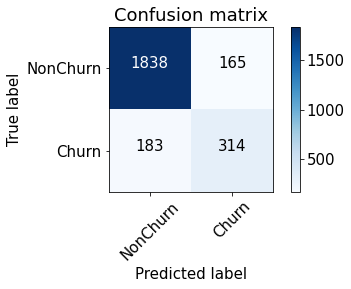

In [39]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_5 > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

__2. Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)__

In [40]:
# Объединим все
results = pd.DataFrame({
    'y_true': y_test,
    'LR': preds_1,
    'BC': preds_2,
    'GBC': preds_3,
    'ABC': preds_4,
    'HGBC': preds_5
})
results['AVG_lr_bc_gbc_abc_hgbc'] = results[['LR', 'BC', 'GBC', 'ABC', 'HGBC']].mean(axis=1)
results['AVG_lr_bc'] = results[['LR', 'BC']].mean(axis=1)
results['AVG_gbc_abc_hgbc'] = results[['GBC', 'ABC', 'HGBC']].mean(axis=1)
results

,y_true,LR,BC,GBC,ABC,HGBC,AVG_lr_bc_gbc_abc_hgbc,AVG_lr_bc,AVG_gbc_abc_hgbc
6252,0,0.243839,0.30,0.049156,0.493028,0.025308,0.222266,0.271920,0.189164
4684,0,0.082235,0.12,0.047173,0.491718,0.032592,0.154744,0.101118,0.190494
1731,0,0.311035,0.34,0.163038,0.495495,0.070270,0.275968,0.325517,0.242935
4742,0,0.430184,0.24,0.232899,0.496877,0.209559,0.321904,0.335092,0.313112
4521,0,0.064062,0.14,0.060217,0.493358,0.076741,0.166876,0.102031,0.210105
...,...,...,...,...,...,...,...,...,...
4862,0,0.384992,0.26,0.587845,0.501164,0.238654,0.394531,0.322496,0.442555
7025,1,0.432433,0.30,0.977865,0.509772,0.972444,0.638503,0.366216,0.820027
7647,0,0.030545,0.06,0.039729,0.490696,0.007968,0.125788,0.045273,0.179464
7161,0,0.255969,0.08,0.175936,0.496682,0.132371,0.228192,0.167985,0.268330


In [41]:
# Посчитаем метрики
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
    
    return thresholds[ix]

In [42]:
lr_th = get_metrics(results['LR'])
bc_th = get_metrics(results['BC'])
gbc_th = get_metrics(results['GBC'])
abc_th = get_metrics(results['ABC'])
hgbc_th = get_metrics(results['HGBC'])
blending_th = get_metrics(results['AVG_lr_bc_gbc_abc_hgbc'])
blending1_th = get_metrics(results['AVG_lr_bc'])
blending2_th = get_metrics(results['AVG_gbc_abc_hgbc'])

Best Threshold=0.9140362540186621, F-Score=nan, Precision=0.000, Recall=0.000
Best Threshold=0.24, F-Score=0.511, Precision=0.410, Recall=0.678
Best Threshold=0.35841976516814406, F-Score=0.619, Precision=0.632, Recall=0.606
Best Threshold=0.4985183117778321, F-Score=0.613, Precision=0.624, Recall=0.604
Best Threshold=0.3419290254840198, F-Score=0.645, Precision=0.656, Recall=0.634
Best Threshold=0.3559525116775314, F-Score=0.635, Precision=0.647, Recall=0.624
Best Threshold=0.2570221322550492, F-Score=0.534, Precision=0.464, Recall=0.628
Best Threshold=0.384922276402102, F-Score=0.644, Precision=0.637, Recall=0.652


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


В задаче оттока, думаю самой важной метрикой будет охват, т.е. recall. По этой метрике лидирует модель BaggingClassifier, на втором месте по этой метрике блендинг из бустингов.

__3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:__

   - 1 доллар на удержание
   - 2 доллара - с каждого правильно классифицированного (True Positive)

In [43]:
cnf_matrix = confusion_matrix(y_test,preds_2>thresholds[ix])
cnf_matrix

array([[1878,  125],
       [ 317,  180]])

In [44]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

In [45]:
add_summ = TP * 2 - np.sum(cnf_matrix[:, 1]) * 1
print('дополнительный доход: ', add_summ )

дополнительный доход:  55


__4. *Провести подбор гиперпараметров лучшей модели по итогам 2-3__

In [46]:
# Сетка с параметрами
from sklearn.model_selection import GridSearchCV

params = {
    'classifier__max_features':[0.3, 0.5, 0.7],
    'classifier__max_samples':[0.3, 0.5, 0.7]
}

In [47]:
# Запускаем перебор
%%time
grid = GridSearchCV(pipeline_2,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1
['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsA

In [48]:
search.best_params_

{'classifier__max_features': 0.5, 'classifier__max_samples': 0.7}

In [49]:
# Добавим модель BaggingClassifier с новыми параметрами
pipeline_6 = Pipeline([
    ('features', feats_1),
    ('classifier', BaggingClassifier(KNeighborsClassifier(), max_samples=0.7, max_features=0.5, random_state=42))
])

In [50]:
# обучим наш пайплайн
pipeline_6.fit(X_train, y_train)

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography')),
                                                                 ('data_for_lr',
                                                                  DataForLr(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OH

In [51]:
# наши прогнозы для тестовой выборки
preds_6 = pipeline_6.predict_proba(X_test)[:, 1]
preds_6[:10]

['Geography_France', 'Geography_Germany', 'Geography_Spain']
Geography_France
Geography_Germany
Geography_Spain
['Gender_Female', 'Gender_Male']
Gender_Female
Gender_Male
['Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10']
Tenure_0
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
Tenure_9
Tenure_10
['HasCrCard_0', 'HasCrCard_1']
HasCrCard_0
HasCrCard_1
['IsActiveMember_0', 'IsActiveMember_1']
IsActiveMember_0
IsActiveMember_1


array([0.3 , 0.12, 0.38, 0.2 , 0.2 , 0.06, 0.16, 0.44, 0.42, 0.22])

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_6)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.27999999999999997, F-Score=0.503, Precision=0.456, Recall=0.559


__5. *Еще раз провести оценку экономической эффективности__

In [53]:
cnf_matrix = confusion_matrix(y_test, preds_6 > thresholds[ix])
cnf_matrix

array([[1697,  306],
       [ 234,  263]])

In [54]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

In [55]:
add_summ = TP * 2 - np.sum(cnf_matrix[:, 1]) * 1
print('дополнительный доход: ', add_summ )

дополнительный доход:  -43
